# Loading functionality into Julia

In [1]:
using StatsFuns, CSV, Cubature, ProgressMeter, DataFrames, Optim, SpecialFunctions, Roots
using Distributions, DelimitedFiles, Random, QuadGK

using Plots, StatsPlots, ColorBrewer
pyplot()

Plots.PyPlotBackend()

In [2]:
Plots.scalefontsizes(1.2)

In [3]:
results_dir = "../../results/Andrei"
results_file = "$(results_dir)/output-onset2report.csv"
run(`mkdir -p $(results_dir)`)

Process(`mkdir -p ../../results/Andrei`, ProcessExited(0))

In [4]:
header = ["dataset","distribution","truncated","CIs","mean","sd","negloglk","AIC",
    "mean_lower","mean_upper","sd_lower","sd_upper"]
header=reshape(header,1,length(header))
open(results_file, "w") do io
    writedlm(io, header, ',')
end

In [5]:
clrs = [ColorBrewer.palette("Blues", 5)[2], ColorBrewer.palette("Blues", 5)[4]];
clrs

In [6]:
## The function is adopted from:
## from https://github.com/robertfeldt/BlackBoxOptim.jl/blob/master/src/utilities/latin_hypercube_sampling.jl
"""
    latin_hypercube_sampling(mins, maxs, numSamples)
    Randomly sample `numSamples` values from the parallelogram defined
    by `mins` and `maxs` using the Latin hypercube algorithm.
"""
function latin_hypercube_sampling(mins::AbstractVector{T},
                                  maxs::AbstractVector{T},
                                  n::Integer) where T<:Number
    length(mins) == length(maxs) ||
        throw(DimensionMismatch("mins and maxs should have the same length"))
    all(xy -> xy[1] <= xy[2], zip(mins, maxs)) ||
        throw(ArgumentError("mins[i] should not exceed maxs[i]"))
    dims = length(mins)
    result = zeros(T, dims, n)
    cubedim = Vector{T}(undef, n)
    @inbounds for i in 1:dims
        imin = mins[i]
        dimstep = (maxs[i] - imin) / n
        for j in 1:n
            cubedim[j] = imin + dimstep * (j - 1 + rand(T))
        end
        result[i, :] .= shuffle!(cubedim)
    end
    return result
end

nsamples = 10000
# for reproducibility we fix the seed of the random number generator
smpls = latin_hypercube_sampling([0.0],[1.0],nsamples);

In [7]:
DIRNAME = "data_tmp_julia"
t0 = "2019-12-09"
CUTOFF_DATE = "2020-01-24"
run(`mkdir -p $DIRNAME`)
run(`Rscript prepare_data.R ./$DIRNAME $t0 $CUTOFF_DATE`)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Joining, by = "date"


Process(`Rscript prepare_data.R ./data_tmp_julia 2019-12-09 2020-01-24`, ProcessExited(0))

# Loading the dataset

## Delay from onset to reporting

In [8]:
df_onset2report = DataFrame(CSV.read("$DIRNAME/data_onset2report.csv"))
df_onset2report[!,:E_L] .= 0
df_onset2report[!,:E_R] .= df_onset2report[!,:E_L] .+ 1
df_onset2report[!,:S_L] .= df_onset2report[!,:dist]
df_onset2report[!,:S_R] .= df_onset2report[!,:dist] .+ 1
df_onset2report[!,:tstar] .= df_onset2report[!,:distUpper]
select!(df_onset2report, Not([:Onset, :dist, :distUpper]))
df_onset2report

,E_L,E_R,S_L,S_R,tstar
,Int64,Int64,Int64,Int64,Int64
1,0,1,13,14,22
2,0,1,8,9,20
3,0,1,2,3,7
4,0,1,6,7,10
5,0,1,6,7,8
6,0,1,3,4,5
7,0,1,10,11,11
8,0,1,2,3,4
9,0,1,14,15,15


In [9]:
dataset = df_onset2report

,E_L,E_R,S_L,S_R,tstar
,Int64,Int64,Int64,Int64,Int64
1,0,1,13,14,22
2,0,1,8,9,20
3,0,1,2,3,7
4,0,1,6,7,10
5,0,1,6,7,8
6,0,1,3,4,5
7,0,1,10,11,11
8,0,1,2,3,4
9,0,1,14,15,15


# MLE

In [10]:
logmean_init = log.(5)
logsd_init = log.(4);

## Gamma distribution

In [11]:
function get_chi2value(CIs)
    if CIs=="95%"
        return 3.84
    elseif CIs=="90%"
        return 2.71
    end
end
        
CIs = "95%"
chi2value = get_chi2value(CIs)

3.84

In [12]:
prog = ProgressThresh(-Inf, "MLE:") 
function getNegativeLoglk_no_truncation(params, df)
    mean_SI = exp(params[1]) # make the parameters positive
    sd_SI = exp(params[2]) # make the parameters positive
    shape = (mean_SI/sd_SI)^2
    invscale = (sd_SI^2)/mean_SI
    loglk = 0
    @inline function Fs(t) 
        gammacdf(shape, invscale, t)
    end
    # this for-loop is based on coarseData R package consolidated to one piece of code
    @simd for k in 1:nrow(df)
        E_R = df[k,:E_R]; E_L = df[k,:E_L]; S_R = df[k,:S_R]; S_L = df[k,:S_L]
        if (S_L!=S_R)
            if (S_L > E_R) # if the intervals do not overlap
                loglk += log(quadgk(e -> (Fs(S_R-e) - Fs(S_L-e)), E_L, E_R)[1])
            elseif (S_L > E_L)
                loglk += log(quadgk(e -> (Fs(S_R-e) - Fs(S_L-e)), E_L, S_L)[1] + 
                    quadgk(e -> Fs(S_R-e), S_L, E_R)[1])
            else
                loglk += log(quadgk(e -> Fs(S_R-e), E_L, E_R)[1])
            end
        else 
            println("There are S_L = S_R!")
        end
    end
    ProgressMeter.update!(prog, -loglk)
    return(-loglk)
end

getNegativeLoglk_no_truncation (generic function with 1 method)

In [13]:
res0 = optimize(x -> getNegativeLoglk_no_truncation(x, dataset), [logmean_init, logsd_init])

println("* Generating the results")
logprms = Optim.minimizer(res0)
prms = exp.(logprms)
println([(prms[1]/prms[2])^2, prms[2]^2/prms[1]])

negloglk = Optim.minimum(res0)
AIC = -2*2 + 2negloglk

res = [prms[1], prms[2], negloglk, AIC]

MLE: (thresh = -Inf, value = 39.6886)

* Generating the results
[1.4227060680596084, 3.7390744669587557]


4-element Array{Float64,1}:
  5.319603933068968
  4.459864935227473
 39.60590826232033 
 75.21181652464065 

In [14]:
println("* profile-based for the mean")
function y(s, x0) 
    y = optimize(x -> getNegativeLoglk_no_truncation([s x], dataset), [x0], BFGS())
    return  Optim.minimum(y) - negloglk - chi2value/2, Optim.minimizer(y)[1]
end

## lower bound
step_ = 0.075
x0 = logprms[1]
y0s = -1.92
sd0 = log(6.)
while y0s<0
    x0 -= step_
    y0s,sd0 = y(x0, sd0)
    println(x0," ",y0s," ",sd0)
end

* profile-based for the mean


MLE: (thresh = -Inf, value = Inf)

1.5963988519108665 -1.8593517046061816 1.4249290011750275


MLE: (thresh = -Inf, value = Inf)

1.5213988519108665 -1.6746166667834839 1.3623904815473389
1.4463988519108666 -1.365586416158406 1.3072501014968265


MLE: (thresh = -Inf, value = 143.866)

1.3713988519108666 -0.9370380129645621 1.258896554246041


MLE: (thresh = -Inf, value = 118.251)

1.2963988519108667 -0.397746209096594 1.2164581125747735


MLE: (thresh = -Inf, value = 101.676)

1.2213988519108667 0.24089214891682253 1.1789334704801753


In [15]:
x0 += step_

1.2963988519108667

In [16]:
step_ = 0.02
y0s = -chi2value/2
while y0s<0
    x0 -= step_
    y0s,sd0 = y(x0, sd0)
    println(x0," ",y0s," ",sd0)
end

1.2763988519108667 -0.2366467906907257 1.2060135494822282
1.2563988519108666 -0.06871271311203309 1.1958988762286147
1.2363988519108666 0.10581526141717923 1.1860945971342682


In [17]:
logprms1_lower = fzero(s -> y(s, sd0), (x0,x0+step_))[1]

MLE: (thresh = -Inf, value = 41.5261)

1.2484357496505658

In [18]:
step_ = 0.1
## upper bound
x0 = logprms[1]
y0s = -chi2value/2
sd0 = log(6.)
while y0s<0
    x0 += step_
    y0s,sd0 = y(x0, sd0)
    println(x0," ",y0s," ",sd0)
end

1.7713988519108665 -1.8179686979650054 1.600157841450412
1.8713988519108666 -1.5308229764254175 1.7168661185548515


MLE: (thresh = -Inf, value = 144.89)

1.9713988519108667 -1.0927199543878938 1.8428696427509967
2.0713988519108666 -0.5401787244575669 1.9755602190196881
2.1713988519108667 0.09303736199812285 2.1125438492220296


In [19]:
x0 -= step_

2.0713988519108666

In [20]:
step_ = 0.02
y0s = -chi2value/2
while y0s<0
    x0 += step_
    y0s,sd0 = y(x0, sd0)
    println(x0," ",y0s," ",sd0)
end

2.0913988519108666 -0.41899611035480966 2.002682893326113
2.1113988519108666 -0.2948513808554889 2.029958564901341
2.1313988519108666 -0.16798133963545858 2.0573708477320634


MLE: (thresh = -Inf, value = 41.4873)

2.1513988519108667 -0.038612842017242244 2.0849041810737097
2.1713988519108667 0.09303736199813706 2.1125438381295014


In [21]:
logprms1_upper = fzero(s -> y(s, sd0), (x0-step_,x0))[1]

MLE: (thresh = -Inf, value = 41.5259)

2.1572994361737825

In [22]:
res_ = exp.([logprms1_lower, logprms1_upper])
res = vcat(res, res_)
means_samples = latin_hypercube_sampling([res_[1]],[res_[2]],nsamples);
res

6-element Array{Float64,1}:
  5.319603933068968 
  4.459864935227473 
 39.60590826232033  
 75.21181652464065  
  3.4848874552690052
  8.647752288825055 

In [23]:
println("* profile-based for the SD")
function y(s, x0) 
    y = optimize(x -> getNegativeLoglk_no_truncation([x[1], s], dataset), [x0], BFGS())
    return  Optim.minimum(y) - negloglk - chi2value/2, Optim.minimizer(y)[1]
end

## lower bound
step_ = 0.2
x0 = logprms[2]
y0s = -chi2value/2
mean0 = log(6.)
while y0s<0
    x0 -= step_
    y0s,mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

* profile-based for the SD


MLE: (thresh = -Inf, value = 528.647)

1.2951184819921318 -1.6230003198198997 1.552655165016523
1.0951184819921318 -0.546368801616067 1.4365648617003768


MLE: (thresh = -Inf, value = 43.203)

0.8951184819921318 1.6770740735115286 1.3206732020045466


In [24]:
logprms2_lower = fzero(s -> y(s, mean0), (x0,x0+step_))[1]

MLE: (thresh = -Inf, value = 41.5259)

1.033054936791718

In [25]:
step_ = 0.15
## upper bound
x0 = logprms[2]
y0s = -chi2value/2
mean0 = log(6.)
while y0s<0
    x0 += step_
    y0s, mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

1.6451184819921316 -1.7883012422844171 1.7629416043145807
1.7951184819921315 -1.441529316476176 1.8568636660937032
1.9451184819921314 -0.9388299574750985 1.9532778062671081


MLE: (thresh = -Inf, value = 42.1495)

2.0951184819921314 -0.32507315831195704 2.052203322889064
2.2451184819921313 0.36573274084918417 2.1536037329880386


In [26]:
x0 -= step_

2.0951184819921314

In [27]:
step_ = 0.01
y0s = -chi2value/2
while y0s<0
    x0 += step_
    y0s, mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

2.105118481992131 -0.2810925181192925 2.0588870037677016
2.115118481992131 -0.23678106039996827 2.065581676909715
2.1251184819921307 -0.192147233342018 2.0722873265825177
2.1351184819921305 -0.14719932891082088 2.079003933644094
2.1451184819921303 -0.10194548635484146 2.0857314784412435
2.15511848199213 -0.056393694952836526 2.0924699406235323
2.16511848199213 -0.01055179671096873 2.099219299191381
2.1751184819921296 0.03557251098979641 2.1059795325567032


In [28]:
logprms2_upper = fzero(s -> y(s, mean0), (x0-step_,x0))[1]

MLE: (thresh = -Inf, value = 41.5266)

2.1674115191376737

In [29]:
res_ = exp.([logprms2_lower, logprms2_upper])
res = vcat(res, res_)
SD_samples = latin_hypercube_sampling([res_[1]],[res_[2]],nsamples);
res

8-element Array{Float64,1}:
  5.319603933068968 
  4.459864935227473 
 39.60590826232033  
 75.21181652464065  
  3.4848874552690052
  8.647752288825055 
  2.809635997761565 
  8.735642706087134 

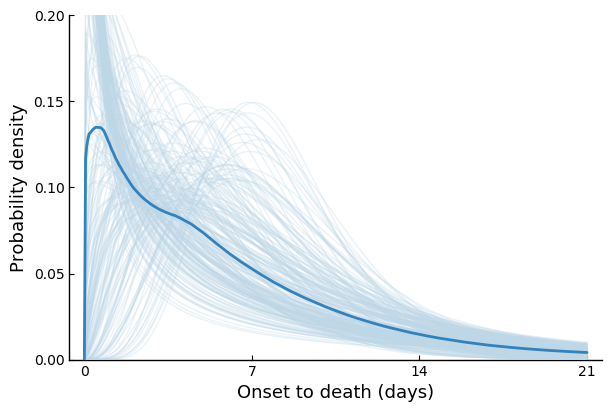

In [30]:
tmax = 21
t = [0:0.05:tmax;]
for idx_ in 1:nsamples
    shape = (means_samples[idx_]/SD_samples[idx_])^2
    scale = SD_samples[idx_]^2/means_samples[idx_]
    if idx_>1
        append!(Y, [pdf.(Distributions.Gamma(shape, scale),t)])
    else 
        global Y
        Y = [pdf.(Distributions.Gamma(shape, scale),t)]
    end
end

plot(t, Y[1:250], legend=false, color=clrs[1], alpha=.3, 
    grid=false, xticks = 0:7:tmax,ylims=((0.,.2)),
    xlabel="Onset to death (days)", ylabel="Probability density",
    size = (600,400))

plot!(t, median(hcat(Y...);dims=2), color=clrs[2], lw=2)

Plots.pdf("$(results_dir)/onset2report-gamma-no_truncation.pdf")

In [31]:
res_final = reshape(vcat(["onset2report", "gamma", "no", CIs],round.(res,digits=3)),1,length(res)+4)
open(results_file, "a") do io
    writedlm(io, res_final, ',')
end

println(res_final)

Any["onset2report" "gamma" "no" "95%" 5.32 4.46 39.606 75.212 3.485 8.648 2.81 8.736]


# Lognormal

In [32]:
lognormalpdf(μ, σ, x) = 1.0/x/σ/sqrt(2.0*pi)*exp(-((log(x)-μ)^2)/2/(σ^2))
lognormalcdf(μ, σ, x) = 0.5 + 0.5*erf((log(x)-μ)/sqrt(2.0)/σ)

lognormalcdf (generic function with 1 method)

In [33]:
function getNegativeLoglk_no_truncation(params, df)
    mean_ = exp(params[1]) # make the parameters positive
    sd_ = exp(params[2]) # make the parameters positive
    σ = sqrt(log(1+(sd_/mean_)^2))
    μ = log(mean_)-(σ^2/2)
    loglk = 0
    @inline function Fs(t) 
        lognormalcdf(μ, σ, t)
    end
    # this for-loop is based on coarseData R package consolidated to one piece of code
    @simd for k in 1:nrow(df)
        E_R = df[k,:E_R]; E_L = df[k,:E_L]; S_R = df[k,:S_R]; S_L = df[k,:S_L]
        if (S_L!=S_R)
            if (S_L > E_R) # if the intervals do not overlap
                loglk += log(quadgk(e -> (Fs(S_R-e) - Fs(S_L-e)), E_L, E_R)[1])
            elseif (S_L > E_L)
                loglk += log(quadgk(e -> (Fs(S_R-e) - Fs(S_L-e)), E_L, S_L)[1] + 
                    quadgk(e -> Fs(S_R-e), S_L, E_R)[1])
            else
                loglk += log(quadgk(e -> Fs(S_R-e), E_L, E_R)[1])
            end
        else 
            println("There are S_L = S_R!")
        end
    end
    ProgressMeter.update!(prog, -loglk)
    return(-loglk)
end

getNegativeLoglk_no_truncation (generic function with 1 method)

In [34]:
res0 = optimize(x -> getNegativeLoglk_no_truncation(x, dataset), [logmean_init, logsd_init])

println("* Generating the results")
logprms = Optim.minimizer(res0)
prms = exp.(logprms)
mean_ = sqrt(log(1+(prms[2]/prms[1])^2))
println([mean_ , log(mean_)-(prms[2]^2/2)])

negloglk = Optim.minimum(res0)
AIC = -2*2 + 2negloglk

res = [prms[1], prms[2], negloglk, AIC]

MLE: (thresh = -Inf, value = 40.7529)

* Generating the results
[0.9172160695734822, -20.68000136374481]


4-element Array{Float64,1}:
  5.587295505771084
  6.417723764052663
 39.72929627237824 
 75.45859254475648 

In [35]:
println("* profile-based for the mean")
function y(s, x0) 
    y = optimize(x -> getNegativeLoglk_no_truncation([s x], dataset), [x0], BFGS())
    return  Optim.minimum(y) - negloglk - chi2value/2, Optim.minimizer(y)[1]
end

## lower bound
step_ = 0.075
x0 = logprms[1]
y0s = -1.92
sd0 = log(6.)
while y0s<0
    x0 -= step_
    y0s,sd0 = y(x0, sd0)
    println(x0," ",y0s," ",sd0)
end

* profile-based for the mean


MLE: (thresh = -Inf, value = 39.7819)

1.6454953607502285 -1.8829754978206434 1.7465667988108118
1.5704953607502286 -1.7636996965541822 1.6415897478671568
1.4954953607502286 -1.550857731993295 1.5450334814389135
1.4204953607502286 -1.2355466050998398 1.4574981387143133
1.3454953607502287 -0.8123405989663635 1.3791981727307006
1.2704953607502287 -0.27988436326351085 1.3099446404680626
1.1954953607502288 0.3591303604828955 1.2491980260174937


In [36]:
x0 += step_

1.2704953607502287

In [37]:
step_ = 0.02
y0s = -chi2value/2
while y0s<0
    x0 -= step_
    y0s,sd0 = y(x0, sd0)
    println(x0," ",y0s," ",sd0)
end

1.2504953607502287 -0.1197006129933822 1.2929428255770605
1.2304953607502287 0.047983571189158525 1.2765335856673152


In [38]:
logprms1_lower = fzero(s -> y(s, sd0), (x0,x0+step_))[1]

MLE: (thresh = -Inf, value = 41.6973)

1.2361286932968074

In [39]:
step_ = 0.1
## upper bound
x0 = logprms[1]
y0s = -chi2value/2
sd0 = log(6.)
while y0s<0
    x0 += step_
    y0s,sd0 = y(x0, sd0)
    println(x0," ",y0s," ",sd0)
end

1.8204953607502286 -1.8629963050484033 2.0189000833777344
1.9204953607502286 -1.7111205505840328 2.187587614385249
2.0204953607502287 -1.4903619588921782 2.3627784282018283


MLE: (thresh = -Inf, value = 40.4273)

2.120495360750229 -1.2220181948324633 2.542573825625385
2.220495360750229 -0.9225653183779325 2.7255493859479403
2.320495360750229 -0.6042501951391426 2.910691075822186
2.420495360750229 -0.27592162268684994 3.0973041963262697
2.520495360750229 0.05616289531691088 3.2849271348435503


In [40]:
x0 -= step_

2.420495360750229

In [41]:
step_ = 0.02
y0s = -chi2value/2
while y0s<0
    x0 += step_
    y0s,sd0 = y(x0, sd0)
    println(x0," ",y0s," ",sd0)
end

2.440495360750229 -0.20964241762447067 3.134759516618132
2.460495360750229 -0.14325877267161324 3.1722519197575902
2.480495360750229 -0.07680759086408351 3.2097788479977547
2.500495360750229 -0.010323116885102124 3.247337964276219
2.520495360750229 0.05616289531690377 3.2849271348525613


In [42]:
logprms1_upper = fzero(s -> y(s, sd0), (x0-step_,x0))[1]

MLE: (thresh = -Inf, value = 41.6493)

2.503600509654278

In [43]:
res_ = exp.([logprms1_lower, logprms1_upper])
res = vcat(res, res_)
means_samples = latin_hypercube_sampling([res_[1]],[res_[2]],nsamples);
res

6-element Array{Float64,1}:
  5.587295505771084
  6.417723764052663
 39.72929627237824 
 75.45859254475648 
  3.442261586476249
 12.226436207593192

In [44]:
println("* profile-based for the SD")
function y(s, x0) 
    y = optimize(x -> getNegativeLoglk_no_truncation([x[1], s], dataset), [x0], BFGS())
    return  Optim.minimum(y) - negloglk - chi2value/2, Optim.minimizer(y)[1]
end

## lower bound
step_ = 0.2
x0 = logprms[2]
y0s = -chi2value/2
mean0 = log(6.)
while y0s<0
    x0 -= step_
    y0s,mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

* profile-based for the SD


MLE: (thresh = -Inf, value = 40.6834)

1.6590635009469021 -1.8313303909184295 1.623802029473708
1.4590635009469022 -1.5131681766639442 1.5271829787473563
1.2590635009469022 -0.8632362882541837 1.4299983373304732
1.0590635009469023 0.26238461424338944 1.3310396600110692


In [45]:
x0 += step_

1.2590635009469022

In [46]:
step_ = 0.01
y0s = -chi2value/2
while y0s<0
    x0 -= step_
    y0s,mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

1.2490635009469022 -0.819662332861034 1.425105955280597
1.2390635009469022 -0.7748896081214394 1.4202091450001313
1.2290635009469022 -0.7288965771217644 1.415307700942884
1.2190635009469022 -0.6816613432318572 1.4104014110015515
1.2090635009469022 -0.6331616449506239 1.4054900563519346
1.1990635009469022 -0.5833748507240184 1.4005734111236339
1.1890635009469022 -0.5322779537393441 1.3956512424582235
1.1790635009469022 -0.4798475666977975 1.390723309836487
1.1690635009469021 -0.42605991656977515 1.3857893651976316
1.1590635009469021 -0.370890839335841 1.3808491524579072
1.1490635009469021 -0.31431577471790995 1.375902407299956
1.1390635009469021 -0.2563097609045979 1.370948856905873
1.129063500946902 -0.19684742927552001 1.365988219585033
1.119063500946902 -0.13590299912964632 1.3610202045635877
1.109063500946902 -0.07345027242262425 1.3560445115332578
1.099063500946902 -0.00946262851966928 1.3510608304453509
1.089063500946902 0.056086981030817995 1.3460688410466923


In [47]:
logprms2_lower = fzero(s -> y(s, mean0), (x0,x0+step_))[1]

MLE: (thresh = -Inf, value = 41.7054)

1.0976049763147835

In [48]:
step_ = 0.15
## upper bound
x0 = logprms[2]
y0s = -chi2value/2
mean0 = log(6.)
while y0s<0
    x0 += step_
    y0s, mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

2.009063500946902 -1.8802226713555807 1.793282305721847
2.159063500946902 -1.7746888351780026 1.8663649701964709
2.309063500946902 -1.6204873674545706 1.9397782189802677
2.4590635009469017 -1.4307207179477484 2.0135266956432347
2.6090635009469016 -1.2154254024218343 2.087598835407229
2.7590635009469016 -0.9822806669499382 2.161973022456854
2.9090635009469015 -0.7371530780561013 2.236621901902404


MLE: (thresh = -Inf, value = Inf)

3.0590635009469014 -0.4845146769518873 2.3115153855574073


MLE: (thresh = -Inf, value = Inf)

3.2090635009469013 -0.22776402527005324 2.386622718647241


MLE: (thresh = -Inf, value = Inf)

3.359063500946901 0.030527211817402033 2.461913868871754


In [49]:
x0 -= step_

3.2090635009469013

In [50]:
step_ = 0.01
y0s = -chi2value/2
while y0s<0
    x0 += step_
    y0s, mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

3.219063500946901 -0.21056809824248113 2.3916367344394747
3.229063500946901 -0.19336620621213108 2.396651553067075
3.2390635009469007 -0.17615898610822533 2.401667180278078
3.2490635009469004 -0.15894706283643778 2.40668358837855
3.2590635009469002 -0.1417310494854629 2.411700787622763
3.2690635009469 -0.1245115475301315 2.4167187554527687
3.2790635009469 -0.10728914703084591 2.421737483465154
3.2890635009468996 -0.090064426829775 2.4267569767419737
3.2990635009468994 -0.07283795474343968 2.4317772133002866
3.309063500946899 -0.055610287752207554 2.436798184911424
3.319063500946899 -0.03838197218632722 2.4418198919753777
3.3290635009468987 -0.02115354390883617 2.4468423259685106
3.3390635009468985 -0.003925528495392072 2.4518654701266973
3.3490635009468983 0.013301558589228435 2.456889316392663


In [51]:
logprms2_upper = fzero(s -> y(s, mean0), (x0-step_,x0))[1]

3.3413421383341255

In [52]:
res_ = exp.([logprms2_lower, logprms2_upper])
res = vcat(res, res_)
SD_samples = latin_hypercube_sampling([res_[1]],[res_[2]],nsamples);
res

8-element Array{Float64,1}:
  5.587295505771084
  6.417723764052663
 39.72929627237824 
 75.45859254475648 
  3.442261586476249
 12.226436207593192
  2.996979584446367
 28.257026104544572

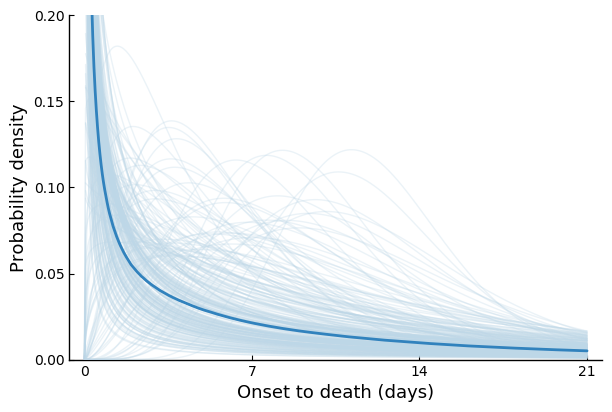

In [53]:
tmax = 21
t = [0:0.05:tmax;]
for idx_ in 1:nsamples
    shape = (means_samples[idx_]/SD_samples[idx_])^2
    scale = SD_samples[idx_]^2/means_samples[idx_]
    if idx_>1
        append!(Y, [pdf.(Distributions.Gamma(shape, scale),t)])
    else 
        global Y
        Y = [pdf.(Distributions.Gamma(shape, scale),t)]
    end
end

plot(t, Y[1:250], legend=false, color=clrs[1], alpha=.3, 
    grid=false, xticks = 0:7:tmax,ylims=((0.,.2)),
    xlabel="Onset to death (days)", ylabel="Probability density",
    size = (600,400))

plot!(t, median(hcat(Y...);dims=2), color=clrs[2], lw=2)

Plots.pdf("$(results_dir)/onset2report-lognormal-no_truncation.pdf")

In [54]:
res_final = reshape(vcat(["onset2report", "lognormal", "no", CIs],round.(res,digits=3)),1,length(res)+4)
open(results_file, "a") do io
    writedlm(io, res_final, ',')
end

println(res_final)

Any["onset2report" "lognormal" "no" "95%" 5.587 6.418 39.729 75.459 3.442 12.226 2.997 28.257]


# Weibull

In [55]:
weibullpdf(α, θ, x) = begin z = x / θ; (α / θ) * z^(α - 1) * exp(-z^α) end
weibullcdf(α, θ, x) = x > 0 ? -expm1(- ((x / θ) ^ α)) : 0.0

weibullcdf (generic function with 1 method)

In [56]:
function getNegativeLoglk_no_truncation(params, df)
    mean_ = exp(params[1]) # make the parameters positive
    α = exp(params[2]) # make the parameters positive
    θ = mean_ / gamma(1 + 1/α)
    loglk = 0
    @inline function Fs(t) 
        weibullcdf(α, θ, t)
    end
    # this for-loop is based on coarseData R package consolidated to one piece of code
    @simd for k in 1:nrow(df)
        E_R = df[k,:E_R]; E_L = df[k,:E_L]; S_R = df[k,:S_R]; S_L = df[k,:S_L]
        if (S_L!=S_R)
            if (S_L > E_R) # if the intervals do not overlap
                loglk += log(quadgk(e -> (Fs(S_R-e) - Fs(S_L-e)), E_L, E_R)[1])
            elseif (S_L > E_L)
                loglk += log(quadgk(e -> (Fs(S_R-e) - Fs(S_L-e)), E_L, S_L)[1] + 
                    quadgk(e -> Fs(S_R-e), S_L, E_R)[1])
            else
                loglk += log(quadgk(e -> Fs(S_R-e), E_L, E_R)[1])
            end
        else 
            println("There are S_L = S_R!")
        end
    end
    ProgressMeter.update!(prog, -loglk)
    return(-loglk)
end

getNegativeLoglk_no_truncation (generic function with 1 method)

In [57]:
res0 = optimize(x -> getNegativeLoglk_no_truncation(x, dataset), 
    [logmean_init, logsd_init])

println("* Generating the results")
logprms = Optim.minimizer(res0)
prms = exp.(logprms)
α = prms[2] 
θ = prms[1] / gamma(1 + 1.0/prms[2])
println("* for note: $(α), $(θ)")
mean_ = prms[1]
α_ = prms[2]
sd_ = mean_ * sqrt(gamma(1.0 + 2.0/α_)/gamma(1.0 + 1.0/α_)^2 - 1.0)


negloglk = Optim.minimum(res0)
AIC = -2*2 + 2negloglk

res = [mean_, sd_, negloglk, AIC]

MLE: (thresh = -Inf, value = 105.194)

* Generating the results
* for note: 1.2333345014361745, 5.700785056341049


4-element Array{Float64,1}:
  5.326230377212036 
  4.3426140737475905
 39.6248851134559   
 75.2497702269118   

In [58]:
println("* profile-based for the mean")
function y(s, x0) 
    y = optimize(x -> getNegativeLoglk_no_truncation([s x], dataset), [x0], BFGS())
    return  Optim.minimum(y) - negloglk - chi2value/2, Optim.minimizer(y)[1]
end

## lower bound
step_ = 0.06
x0 = logprms[1]
y0s = -chi2value/2
α0 = log(4.)
while y0s<0
    x0 -= step_
    y0s, α0 = y(x0, α0)
    println(x0," ",y0s," ",α0)
end

* profile-based for the mean


MLE: (thresh = -Inf, value = 104.405)

1.6126437416594221 -1.879517969197222 0.19924575345963022
1.552643741659422 -1.7578476139797754 0.18298144851994458
1.492643741659422 -1.5564478877594947 0.1619798440393366
1.432643741659422 -1.2786110214190156 0.13720991532760546
1.372643741659422 -0.9288329762812193 0.10951368321807921
1.3126437416594219 -0.5122907133663954 0.07959422540069258
1.2526437416594218 -0.03444834048810286 0.048024574369828224
1.1926437416594218 0.49921897103955537 0.015265192335825297


In [59]:
x0 += step_

1.2526437416594218

In [60]:
step_ = 0.01
y0s = -chi2value/2
while y0s<0
    x0 -= step_
    y0s, α0 = y(x0, α0)
    println(x0," ",y0s," ",α0)
end

1.2426437416594218 0.05076559781694279 0.042636328824958644


In [61]:
logprms1_lower = fzero(s -> y(s, α0), (x0,x0+step_))[1]

MLE: (thresh = -Inf, value = 41.5449)

1.2485793923504578

In [62]:
step_ = 0.06
## upper bound
x0 = logprms[1]
y0s = -chi2value/2
α0 = log(4.)
while y0s<0
    x0 += step_
    y0s,α0 = y(x0, α0)
    println(x0," ",y0s," ",α0)
end

1.7326437416594223 -1.8803195419638836 0.21341849689844106
1.7926437416594223 -1.7644907251095514 0.20951806183589378
1.8526437416594224 -1.5796389157354707 0.19765011650136083
1.9126437416594224 -1.3355526758627274 0.1780262867241538
1.9726437416594225 -1.043672130560756 0.15147100089653795
2.0326437416594225 -0.7157877166438862 0.1192702204632459
2.0926437416594226 -0.3628567706911152 0.08291088842731771
2.1526437416594226 0.005762609605286073 0.04382935993409111


In [63]:
x0 -= step_

2.0926437416594226

In [64]:
step_ = 0.01
y0s = -chi2value/2
while y0s<0
    x0 += step_
    y0s,sd0 = y(x0, α0)
    println(x0," ",y0s," ",α0)
end

2.1026437416594224 -0.30228422754146145 0.04382935993409111
2.112643741659422 -0.2413185314708155 0.04382935993409111
2.122643741659422 -0.1799964620491874 0.04382935993409111
2.1326437416594217 -0.11835329921625792 0.04382935993409111
2.1426437416594215 -0.05642283498547407 0.04382935993409111
2.1526437416594213 0.005762609605278968 0.04382935993409111


In [65]:
logprms1_upper = fzero(s -> y(s, α0), (x0-step_,x0))[1]

MLE: (thresh = -Inf, value = 41.5449)

2.1517186471984022

In [66]:
res_ = exp.([logprms1_lower, logprms1_upper])
res = vcat(res, res_)
means_samples = latin_hypercube_sampling([res_[1]],[res_[2]],nsamples);
res

6-element Array{Float64,1}:
  5.326230377212036 
  4.3426140737475905
 39.6248851134559   
 75.2497702269118   
  3.485388069865855 
  8.599625426032429 

In [67]:
println("* profile-based for the SD")
function y(s, x0) 
    y = optimize(x -> getNegativeLoglk_no_truncation([x[1], s], dataset), [x0], BFGS())
    return  Optim.minimum(y) - negloglk - chi2value/2, Optim.minimizer(y)[1]
end

## lower bound
step_ = 0.2
x0 = logprms[2]
y0s = -chi2value/2
mean0 = log(6.)
while y0s<0
    x0 -= step_
    y0s,mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

* profile-based for the SD


MLE: (thresh = -Inf, value = 40.1403)

0.00972147809203236 -1.5177271397753795 1.667271737758386
-0.19027852190796765 -0.4370287172565721 1.7085961354178794
-0.39027852190796763 1.1592363885487078 1.8153892657175814


In [68]:
x0 += step_

-0.19027852190796762

In [69]:
step_ = 0.01
y0s = -chi2value/2
while y0s<0
    x0 -= step_
    y0s,mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

-0.20027852190796763 -0.3682526976513696 1.7122025602832294
-0.21027852190796764 -0.2982127908724106 1.7159741198047485
-0.22027852190796765 -0.2269268741501076 1.719913531503722
-0.23027852190796766 -0.15441261747209545 1.7240235499166998
-0.24027852190796767 -0.0806874846606842 1.7283069684609669
-0.2502785219079677 -0.0057687344824355336 1.7327666186843396
-0.2602785219079677 0.07032657821043564 1.7374053719957665


In [70]:
logprms2_lower = fzero(s -> y(s, mean0), (x0,x0+step_))[1]

MLE: (thresh = -Inf, value = 41.6152)

-0.25104203896197036

In [71]:
step_ = 0.1
## upper bound
x0 = logprms[2]
y0s = -chi2value/2
mean0 = log(5.)
while y0s<0
    x0 += step_
    y0s, mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

MLE: (thresh = -Inf, value = 39.8275)

0.3097214780920324 -1.806248480636098 1.6881872093030421
0.4097214780920324 -1.4459012856952977 1.7102740933723055
0.5097214780920324 -0.808731344358554 1.7375893976078474
0.6097214780920324 0.13765538258872745 1.7689749951625267


In [72]:
x0 -= step_

0.5097214780920324

In [73]:
step_ = 0.01
y0s = -chi2value/2
while y0s<0
    x0 += step_
    y0s, mean0 = y(x0, mean0)
    println(x0," ",y0s," ",mean0)
end

MLE: (thresh = -Inf, value = 96.197)m

0.5197214780920324 -0.7285607943090948 1.74056268810179
0.5297214780920324 -0.6452662972114194 1.7435754900035638
0.5397214780920324 -0.558814044085933 1.7466267362224863
0.5497214780920324 -0.46917000539882814 1.7497153739215425
0.5597214780920324 -0.37629993033721654 1.7528403586109418
0.5697214780920324 -0.2801693456515988 1.7560006659018699
0.5797214780920324 -0.18074355517778962 1.7591952794026957
0.5897214780920325 -0.0779876384983691 1.7624231966530768
0.5997214780920325 0.028133550059488144 1.7656834277005697


In [74]:
logprms2_upper = fzero(s -> y(s, mean0), (x0-step_,x0))[1]

0.5971012467384091

In [75]:
res_ = exp.([logprms2_lower, logprms2_upper])
α_samples = latin_hypercube_sampling([res_[1]],[res_[2]],nsamples);
SD_samples = []
for idx in 1:nsamples
    append!(SD_samples,[means_samples[idx]*sqrt(gamma(1.0+2.0/α_samples[idx])/(gamma(1.0+1.0/α_samples[idx]))^2-1.0)])
end
res_ = [minimum(SD_samples), maximum(SD_samples)]
res = vcat(res, res_)
res

8-element Array{Float64,1}:
  5.326230377212036 
  4.3426140737475905
 39.6248851134559   
 75.2497702269118   
  3.485388069865855 
  8.599625426032429 
  2.008592516069388 
 10.898389563529149 

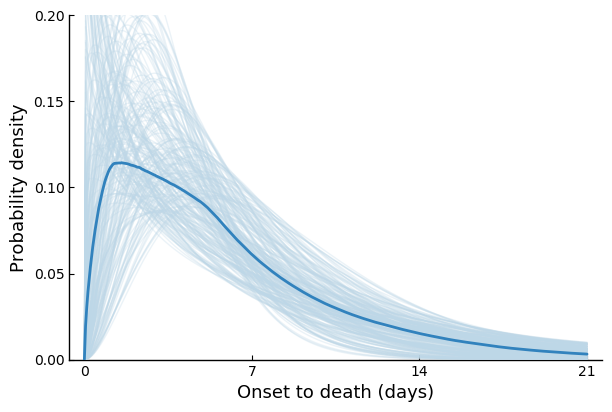

In [76]:
tmax = 21
t = [0:0.05:tmax;]
for idx_ in 1:nsamples
    shape = (means_samples[idx_]/SD_samples[idx_])^2
    scale = SD_samples[idx_]^2/means_samples[idx_]
    if idx_>1
        append!(Y, [pdf.(Distributions.Gamma(shape, scale),t)])
    else 
        global Y
        Y = [pdf.(Distributions.Gamma(shape, scale),t)]
    end
end

plot(t, Y[1:250], legend=false, color=clrs[1], alpha=.3, 
    grid=false, xticks = 0:7:tmax,ylims=((0.,.2)),
    xlabel="Onset to death (days)", ylabel="Probability density",
    size = (600,400))

plot!(t, median(hcat(Y...);dims=2), color=clrs[2], lw=2)

Plots.pdf("$(results_dir)/onset2report-weibull-no_truncation.pdf")

In [77]:
res_final = reshape(vcat(["onset2report", "weibull", "no", CIs],round.(res,digits=3)),1,length(res)+4)
open(results_file, "a") do io
    writedlm(io, res_final, ',')
end

println(res_final)

Any["onset2report" "weibull" "no" "95%" 5.326 4.343 39.625 75.25 3.485 8.6 2.009 10.898]


# Exponential

In [78]:
exponentialpdf(λ, x) = x < 0 ? zero(λ) : λ * exp(-λ * x)
exponentialcdf(λ, x) = x > 0 ? -expm1(-(x / λ)) : 0.0

exponentialcdf (generic function with 1 method)

In [79]:
function getNegativeLoglk_no_truncation(params, df)
    mean_ = exp(params[1]) 
    λ = mean_ 
    loglk = 0
    @inline function Fs(t) 
        exponentialcdf(λ, t)
    end
    # this for-loop is based on coarseData R package consolidated to one piece of code
    @simd for k in 1:nrow(df)
        E_R = df[k,:E_R]; E_L = df[k,:E_L]; S_R = df[k,:S_R]; S_L = df[k,:S_L]
        if (S_L!=S_R)
            if (S_L > E_R) # if the intervals do not overlap
                loglk += log(quadgk(e -> (Fs(S_R-e) - Fs(S_L-e)), E_L, E_R)[1])
            elseif (S_L > E_L)
                loglk += log(quadgk(e -> (Fs(S_R-e) - Fs(S_L-e)), E_L, S_L)[1] + 
                    quadgk(e -> Fs(S_R-e), S_L, E_R)[1])
            else
                loglk += log(quadgk(e -> Fs(S_R-e), E_L, E_R)[1])
            end
        else 
            println("There are S_L = S_R!")
        end
    end
    ProgressMeter.update!(prog, -loglk)
    return(-loglk)
end

getNegativeLoglk_no_truncation (generic function with 1 method)

In [80]:
res0 = optimize(x -> getNegativeLoglk_no_truncation(x, dataset), 
    [logmean_init], BFGS())

println("* Generating the results")
logprms = Optim.minimizer(res0)
prms = exp.(logprms)
mean_ = prms[1]
sd_ = mean_ 

negloglk = Optim.minimum(res0)
AIC = -2 + 2negloglk

res = [mean_, sd_, negloglk, AIC]

MLE: (thresh = -Inf, value = 40.0916)

* Generating the results


4-element Array{Float64,1}:
  5.301916783534935
  5.301916783534935
 40.06545432819064 
 78.13090865638128 

In [81]:
println("* profile-based for the mean")
function y(s) 
    return  getNegativeLoglk_no_truncation(s, dataset) - negloglk - chi2value/2
end

## lower bound
step_ = 0.06
x0 = logprms[1]
y0s = -chi2value/2
while y0s<0
    x0 -= step_
    y0s = y(x0)
    println(x0," ",y0s)
end

* profile-based for the mean


MLE: (thresh = -Inf, value = 40.0928)

1.6080684124465914 -1.892621520765351
1.5480684124465913 -1.8082686715829919
1.4880684124465913 -1.663465613577328
1.4280684124465912 -1.4545275703859257
1.3680684124465912 -1.1775486648557614
1.3080684124465911 -0.8283890979570057
1.248068412446591 -0.40266164069932664
1.188068412446591 0.10428259066218182


In [82]:
x0 += step_

1.248068412446591

In [83]:
step_ = 0.01
y0s = -chi2value/2
while y0s<0
    x0 -= step_
    y0s = y(x0)
    println(x0," ",y0s)
end

1.238068412446591 -0.32394050190428025
1.228068412446591 -0.24294171157937505
1.218068412446591 -0.15964280204610581
1.208068412446591 -0.07402108829530896
1.198068412446591 0.013946334028931417


In [84]:
logprms1_lower = fzero(s -> y(s), (x0,x0+step_))[1]

1.1996360788090803

In [85]:
step_ = 0.06
## upper bound
x0 = logprms[1]
y0s = -chi2value/2
while y0s<0
    x0 += step_
    y0s = y(x0)
    println(x0," ",y0s)
end

1.7280684124465915 -1.8936825448304528
1.7880684124465915 -1.8167611204543643
1.8480684124465916 -1.6921515808083551
1.9080684124465916 -1.5226034802569668
1.9680684124465917 -1.3107093635905311
2.0280684124465918 -1.0589135592074168
2.088068412446592 -0.7695204995053384
2.148068412446592 -0.44470259164361714
2.208068412446592 -0.0865076609684845
2.268068412446592 0.30313401147616226


In [86]:
logprms1_upper = fzero(s -> y(s), (x0-step_,x0))[1]

2.2218065705915593

In [87]:
res_ = exp.([logprms1_lower, logprms1_upper])
res = vcat(res, res_, res_)
means_samples = latin_hypercube_sampling([res_[1]],[res_[2]],nsamples);
res

8-element Array{Float64,1}:
  5.301916783534935 
  5.301916783534935 
 40.06545432819064  
 78.13090865638128  
  3.3189088816612387
  9.223979593073741 
  3.3189088816612387
  9.223979593073741 

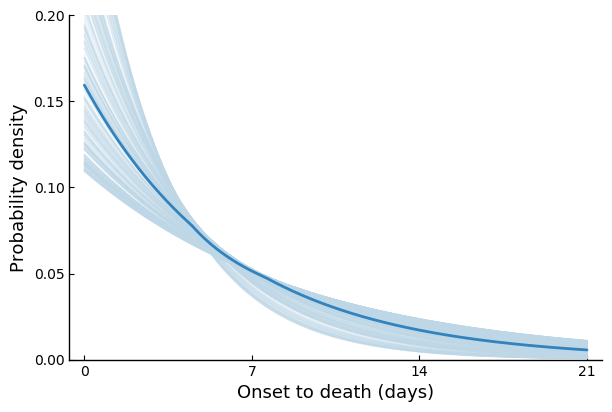

In [88]:
tmax = 21
t = [0:0.05:tmax;]
for idx_ in 1:nsamples
    lamb = means_samples[idx_]
    if idx_>1
        append!(Y, [pdf.(Distributions.Exponential(lamb),t)])
    else 
        global Y
        Y = [pdf.(Distributions.Exponential(lamb),t)]
    end
end

plot(t, Y[1:250], legend=false, color=clrs[1], alpha=.3, 
    grid=false, xticks = 0:7:tmax,ylims=((0.,.2)),
    xlabel="Onset to death (days)", ylabel="Probability density",
    size = (600,400))

plot!(t, median(hcat(Y...);dims=2), color=clrs[2], lw=2)

Plots.pdf("$(results_dir)/onset2report-weibull-no_truncation.pdf")

In [89]:
res_final = reshape(vcat(["onset2report", "exponential", "no", CIs],round.(res,digits=3)),1,length(res)+4)
open(results_file, "a") do io
    writedlm(io, res_final, ',')
end

println(res_final)

Any["onset2report" "exponential" "no" "95%" 5.302 5.302 40.065 78.131 3.319 9.224 3.319 9.224]
